# Set Up and Data Processing

In [1]:
! ls

capstone			    README.md
capstone2.py			    trial2-load-explore-dl.ipynb
config.yml			    trial3-competition-df-dl.ipynb
connect-storage-bucket-trial.ipynb  trial4-atelectasis.ipynb
data				    trial5-data-processing-script-test.ipynb
initial-load-exploration-dl.ipynb   trial-data-exploration.ipynb


In [2]:
! ls data

CheXpert-v1.0-small  models  train_atel.csv


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [6]:
gcp_path = os.getcwd()
gcp_path

'/home/jupyter/springboard-capstone-2'

In [7]:
! mv ~/.fastai ~/.fastai-old

In [8]:
!ln -s /home/jupyter/springboard-capstone-2 ~/.fastai

In [9]:
path = Config.data_path()
# path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [15]:
# import capstone to process data frame
from capstone import data

In [17]:
train_df, valid_df = data.data_processing(path, 'Atelectasis', 1, 0.05);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
                                                 Path     Sex  Age  \
4   CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   
44  CheXpert-v1.0-small/train/patient00015/study1/...  Female   76   
45  CheXpert-v1.0-small/train/patient00015/study2/...  Female   76   
93  CheXpert-v1.0-small/train/patient00028/study1/...    Male   70   
94  CheXpert-v1.0-small/train/patient00028/study2/...    Male   71   

   Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
4          Frontal    AP         NaN                         NaN   
44         Frontal    AP         NaN                         NaN   
45         Frontal    AP         NaN                         NaN   
93         Frontal    PA         NaN                         0.0   
94         Frontal    AP         NaN                         NaN

In [18]:
train_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00003/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00015/study1/...,0.0
2,CheXpert-v1.0-small/train/patient00015/study2/...,-1.0
3,CheXpert-v1.0-small/train/patient00028/study1/...,-1.0
4,CheXpert-v1.0-small/train/patient00028/study2/...,1.0


In [19]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# Further Training of Atelectasis Model 
### Utilizing _U-Ones_ Uncertainty Model)

In [20]:
train_df['Atelectasis'].value_counts(normalize=True)

 0.0    0.698601
 1.0    0.152903
-1.0    0.148497
Name: Atelectasis, dtype: float64

In [22]:
valid_df['Atelectasis'].value_counts(normalize=True)

0.0    0.65812
1.0    0.34188
Name: Atelectasis, dtype: float64

In [24]:
# reassign -1 to 1 
train_df = train_df.replace(to_replace=-1.0, value=1)
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [25]:
train_df['Atelectasis'].value_counts(normalize=True)

0    0.698601
1    0.301399
Name: Atelectasis, dtype: float64

### Training

In [26]:
tfms = get_transforms(True, False, max_rotate=None, max_zoom=0., max_lighting=0.3,
                      max_warp=0, p_affine=0.5, p_lighting=0.5, xtra_tfms=[])

In [27]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [28]:
src = src.split_by_rand_pct(0.2)

In [30]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=8
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 7601MB of GPU RAM free


In [31]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=224)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [32]:
from sklearn.metrics import roc_auc_score

class AUC(Callback):
    "AUC score"
    def __init__(self):
        pass
    
    def on_epoch_begin(self, **kwargs): 
        self.outputs = []
        self.targets = []

    def on_batch_end(self, last_output, last_target, **kwargs):
        "expects binary output with data.c=2 "
        self.outputs += list(to_np(last_output)[:, 1])
        self.targets += list(to_np(last_target))

    def on_epoch_end(self, last_metrics, **kwargs): 
        return {'last_metrics': last_metrics + [roc_auc_score(self.targets, self.outputs)]}
auc = AUC()

In [33]:
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[accuracy, auc])

In [34]:
# load weights from previously trained model
learn.load('atelectasis-stage-2-dn121');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


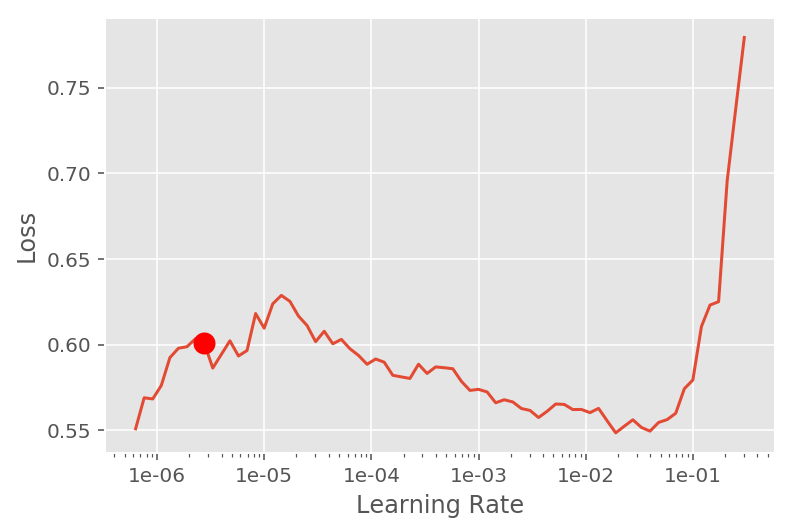

In [35]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [36]:
# access point where the gradient is steepest, first guess for LR
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

2.754228703338166e-06

In [37]:
learn.fit(3, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.612846,0.594914,0.702808,0.601613,02:49
1,0.595658,0.593283,0.702808,0.604934,02:44
2,0.599230,0.593313,0.702808,0.604681,02:44


Min numerical gradient: 2.75E-06


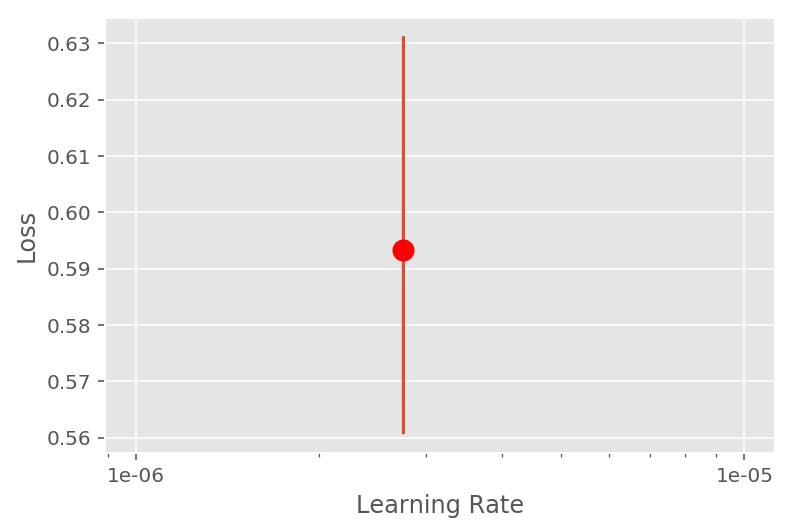

In [38]:
learn.recorder.plot(suggestion=True)

In [39]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.637651,0.606324,0.703240,0.563457,02:44
1,0.626449,0.611263,0.702376,0.562841,02:45
2,0.618216,0.597817,0.702808,0.587230,02:46


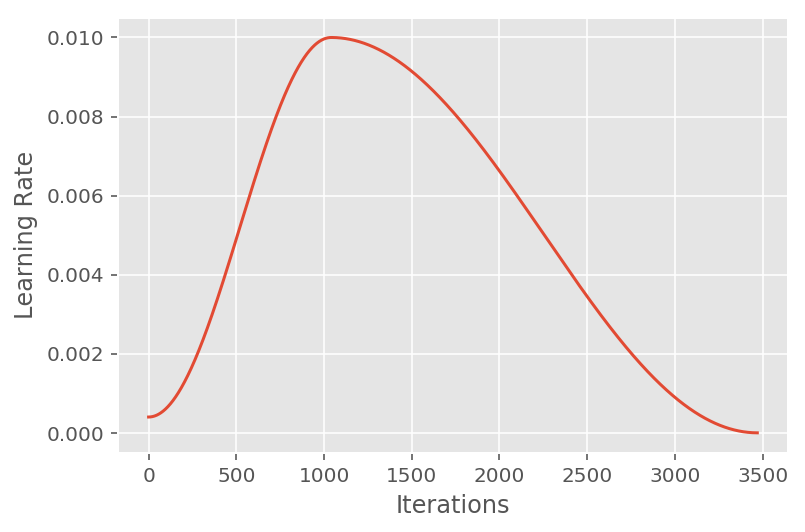

In [40]:
learn.recorder.plot_lr()

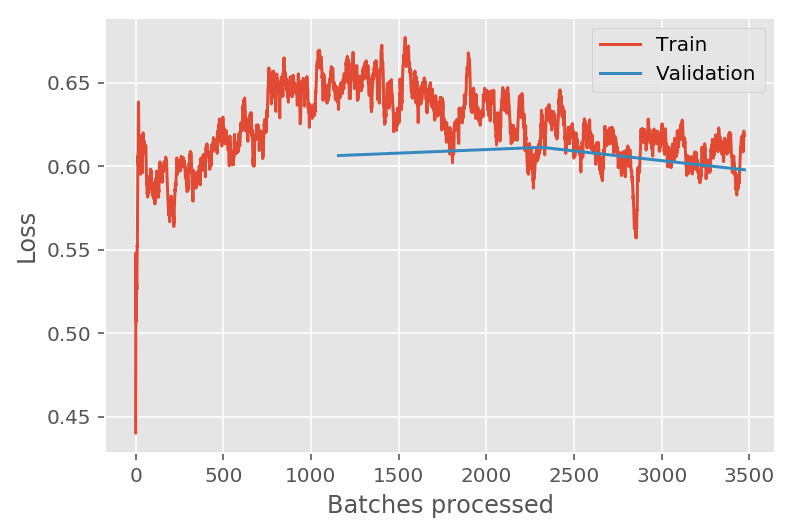

In [41]:
learn.recorder.plot_losses()

Min numerical gradient: 4.07E-04


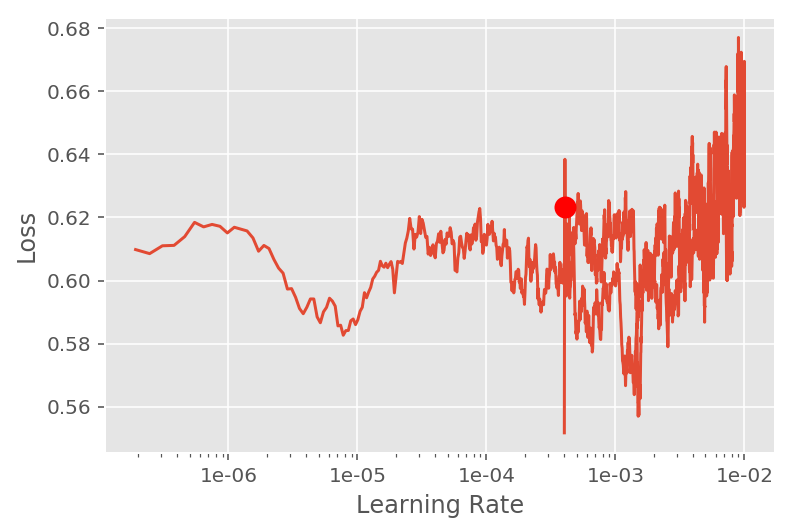

In [42]:
learn.recorder.plot(suggestion=True)

In [43]:
# save process so far
#learn.save('atelectasis-stage-3-dn121')